# Summary

Sometimes borrowers are not paying back their loans from back.
Bad debt is written off by the banks, but even then different strategies can
be applied to collect at least some amount of the credit amount for
example by making a phone call and talk personally to the customer.

However, is the gain to collect a part of the sum worth the effort?
Given some assumptions about the defaulter the bank can come up with an
expected recovery amount. The higher the expected recovery amount the more
effort should the bank put into collection. The higher the effort the higher the cost (\$50 per recovery level). Based on this the bank implements
different recovery strategies or a bundle of actions at different levels or thresholds of expected recovery amounts (1000, 2000, 3000, 5000).
The additional cost at each threshold must be at least covered by the
additional collection. Is this the case?

Still does the recovery system work?
The bank has conducted this approach for some time and has gathered data
about actual recovery amounts. A simple approach would be to calculate the
difference between actual recovery amounts and expected recovery amounts.
The overall difference is positive for this sample is positive.
However even if the overall difference is positive for this sample is positive. this "snapshot" says nothing about the significance of the
difference. Is the sample of recovery amounts generalizable
to the population of recovery amounts?
For this conclusion methods of statistical inference are necessary.

<p>
This project methods of data munging, visualization and inferential statistic:
</p>

<ul>
<li>data import</li>
<li>data exploration</li>
<li>statistics</li>
<li>data aggregation</li>
<li>data visualization</li>
<li>Kruskal-Wallis H-test</li>
<li>Chi-square test</li>
<li>Regression analysis</li>

</ul>

<p>
Comments are and explanations are given within the coding.
A conclusion is made at the end.
</p> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
print("numpy version: ", np.__version__)
import scipy.stats
from scipy import stats
import statsmodels.api as sm
import math
import os
import types
from random import sample
from random import choices
import random
import warnings


numpy version:  1.16.2


In [62]:
working_directory = os.getcwd()

### Import the data

In [3]:
debt = pd.read_csv('debtrecoverydata_complete_2.csv', sep=';',
                   header=0, index_col='index')

### Explore the data

In [4]:
debt.shape

(1882, 6)

In [5]:
debt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1882 entries, 0 to 1881
Data columns (total 6 columns):
id                          1882 non-null int64
expected_recovery_amount    1882 non-null int64
actual_recovery_amount      1882 non-null int64
recovery_strategy           1882 non-null object
age                         1882 non-null int64
sex                         1882 non-null object
dtypes: int64(4), object(2)
memory usage: 102.9+ KB


In [6]:
debt.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
index,,,,,,
0,2030,194,264,Level0Recovery,19,Male
1,1150,486,416,Level0Recovery,25,Female
2,380,527,429,Level0Recovery,27,Male
3,1838,536,297,Level0Recovery,25,Male
4,1995,541,346,Level0Recovery,34,Male


In [7]:
debt.tail()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
index,,,,,,
1877,361,9785,15388,Level4Recovery,65,Female
1878,196,9857,9710,Level4Recovery,68,Female
1879,313,9859,30209,Level4Recovery,58,Female
1880,1781,9920,20386,Level4Recovery,67,Female
1881,522,9964,16706,Level4Recovery,53,Male


In [8]:
statistics = debt.describe()
print(type(statistics))
print(statistics)


<class 'pandas.core.frame.DataFrame'>
                id  expected_recovery_amount  actual_recovery_amount  \
count  1882.000000               1882.000000             1882.000000   
mean   1035.596174               2759.967588             4000.965994   
std     591.458429               2019.826565             4576.498493   
min       6.000000                194.000000              200.000000   
25%     534.250000               1261.250000             1045.000000   
50%    1029.500000               2062.000000             2115.500000   
75%    1551.750000               3569.500000             5417.500000   
max    2056.000000               9964.000000            34398.000000   

               age  
count  1882.000000  
mean     39.650372  
std      15.453072  
min      18.000000  
25%      28.000000  
50%      35.000000  
75%      50.000000  
max      84.000000  


In [9]:
spread = statistics.loc['max'] - statistics.loc['min']
spread.astype('int')

id                           2050
expected_recovery_amount     9770
actual_recovery_amount      34198
age                            66
dtype: int32

#### Difference between actual recovery amounts and expected recovery amounts.

In [59]:
diff_amount = debt['actual_recovery_amount'] - debt['expected_recovery_amount']
diff_amount[:5]
diff_amount.sum()

2335559

In [ ]:
The overall difference is positive for this sample is positive.
However this "snapshot" says nothing about the significance of the
difference. For this conclusion methods of statistical inference are
necessary.

### Aggregation

In [10]:
# Determining the spread of the recovery levels.
recover_agg = debt.groupby('recovery_strategy')['expected_recovery_amount'].aggregate(['min', 'max'])
print(type(recover_agg))
recover_agg['range'] = recover_agg['max'] - recover_agg['min']
print(recover_agg )
print(recover_agg.shape)
print(recover_agg.index)

<class 'pandas.core.frame.DataFrame'>
                    min   max  range
recovery_strategy                   
Level0Recovery      194  1000    806
Level1Recovery     1001  1997    996
Level2Recovery     2001  2992    991
Level3Recovery     3002  4987   1985
Level4Recovery     5008  9964   4956
(5, 3)
Index(['Level0Recovery', 'Level1Recovery', 'Level2Recovery', 'Level3Recovery',
       'Level4Recovery'],
      dtype='object', name='recovery_strategy')


In [11]:
# subsetting minimum colum from recover_agg above, 
# this are threshold values
recover_agg_min = recover_agg.loc['Level1Recovery':'Level4Recovery','min']
thresholds_df = recover_agg_min.to_frame()
thresholds_df.reset_index(inplace=True)

thresholds_df['low'] = thresholds_df['min'] - 100
thresholds_df['up'] = thresholds_df['min'] + 100
thresholds_df['recovery_strategy'] = ['threshold_0_1', 'threshold_1_2', 'threshold_2_3', 'threshold_3_4']
thresholds_df.rename(columns={'recovery_strategy': 'threshold_areas'}, inplace=True)

print(type(thresholds_df))
print(thresholds_df)



<class 'pandas.core.frame.DataFrame'>
  threshold_areas   min   low    up
0   threshold_0_1  1001   901  1101
1   threshold_1_2  2001  1901  2101
2   threshold_2_3  3002  2902  3102
3   threshold_3_4  5008  4908  5108


In [12]:
# Creating lower and upper boundaries
low = thresholds_df.low.to_list()
print(low)
up = thresholds_df.up.to_list()
print(up)
threshold_areas = thresholds_df.threshold_areas.to_list()
print(threshold_areas)

[901, 1901, 2902, 4908]
[1101, 2101, 3102, 5108]
['threshold_0_1', 'threshold_1_2', 'threshold_2_3', 'threshold_3_4']


In [13]:
# check boundaries
for i,m  in zip(low,up):
    print(i,m)

901 1101
1901 2101
2902 3102
4908 5108


## Plotting variables

In [14]:
int_cols = debt.select_dtypes(include='int64')
print(int_cols.shape)
print(type(int_cols))

(1882, 4)
<class 'pandas.core.frame.DataFrame'>


#### Numerical variables

In [15]:
intcols_names = int_cols.columns.to_list()
intcols_names

['id', 'expected_recovery_amount', 'actual_recovery_amount', 'age']

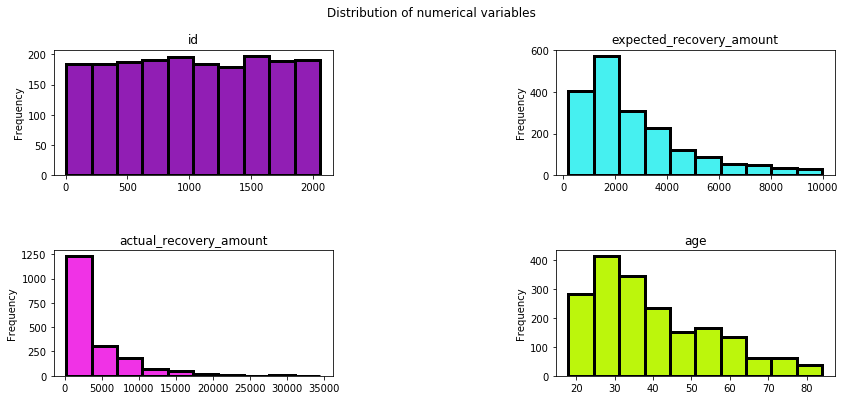

In [16]:
color_list=['#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#f58231', '#911eb4', '#46f0f0', '#f032e6']

fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(hspace=0.6, wspace=0.8)
fig.suptitle("Distribution of numerical variables")
for u,(i,j) in enumerate(zip(range(1,5), intcols_names)):
        ax = fig.add_subplot(2, 2, i)
        ax = int_cols[j].plot.hist(color=color_list[i], edgecolor="black",
                                  title=intcols_names[u], linewidth=3)

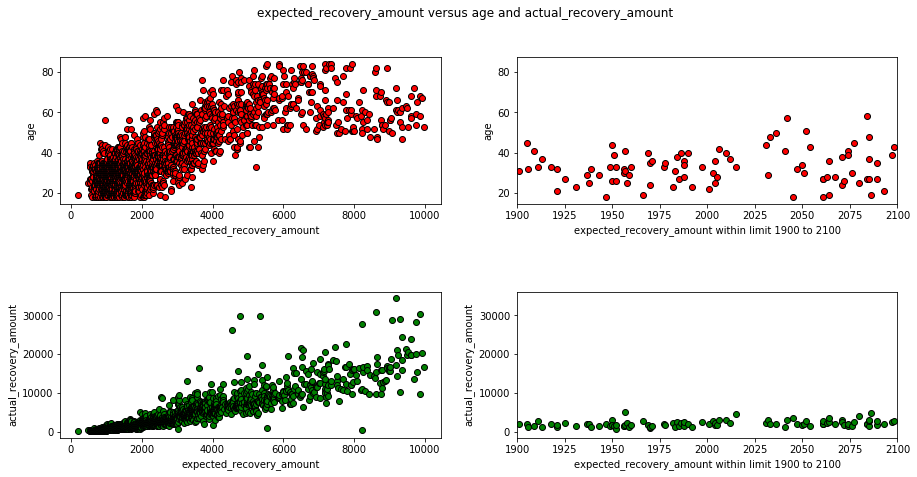

In [17]:
fig, axes= plt.subplots(2,2, figsize=(15,7))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle("expected_recovery_amount versus age and actual_recovery_amount")

axes[0,0].scatter(debt['expected_recovery_amount'], debt['age'], c='r', edgecolor='black')
axes[0,0].set_xlabel('expected_recovery_amount')
axes[0,0].set_ylabel('age')

axes[0,1].scatter(debt['expected_recovery_amount'], debt['age'], c='r', edgecolor='black')
axes[0,1].set_xlim(1900,2100)
axes[0,1].set_xlabel('expected_recovery_amount within limit 1900 to 2100')
axes[0,1].set_ylabel('age')


axes[1,0].scatter(debt['expected_recovery_amount'], debt['actual_recovery_amount'], c='g', edgecolor='black')
axes[1,0].set_ylabel('actual_recovery_amount')
axes[1,0].set_xlabel('expected_recovery_amount')

axes[1,1].scatter(debt['expected_recovery_amount'], debt['actual_recovery_amount'], c='g', edgecolor='black')
axes[1,1].set_xlim(1900,2100)
axes[1,1].set_ylabel('actual_recovery_amount')
axes[1,1].set_xlabel('expected_recovery_amount within limit 1900 to 2100')

plt.show()

#### Categorical variables

In [18]:
cat_cols = debt.select_dtypes(include='object')
cat_cols_names = cat_cols.columns.to_list()
print(cat_cols.shape)
print(cat_cols_names)

(1882, 2)
['recovery_strategy', 'sex']


In [19]:
for i, b in enumerate(cat_cols):
    print(i,b)

0 recovery_strategy
1 sex


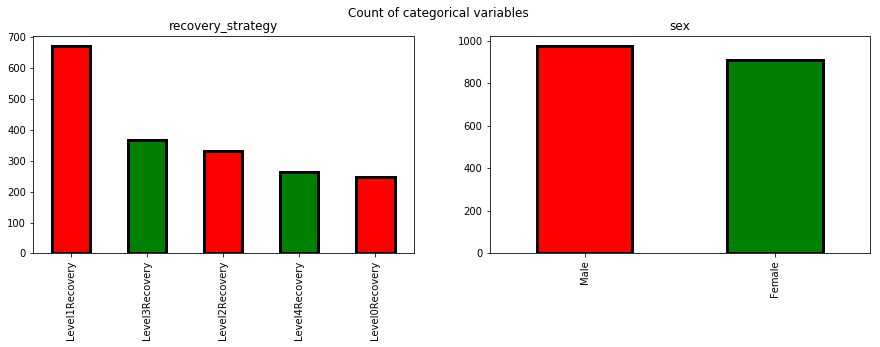

In [20]:
fig = plt.figure(figsize=(15,4))
plt.suptitle("Count of categorical variables")
for j, (u,n) in enumerate(zip(range(1,3), cat_cols_names)):
    ax = fig.add_subplot(1,2, u)
    ax = cat_cols[n].value_counts().plot.bar(title = cat_cols_names[j],
                                             color = ['r', 'g'],
                                             edgecolor='black', linewidth=3)

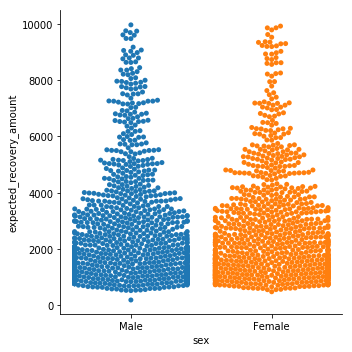

In [21]:
g=sns.catplot(x="sex", y='expected_recovery_amount', kind="swarm", data=debt);


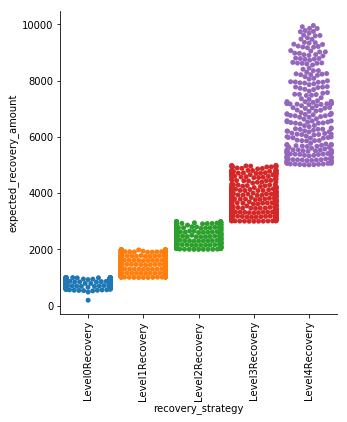

In [22]:
ax=sns.catplot(x="recovery_strategy", y='expected_recovery_amount', kind="swarm", data=debt)
ax.set_xticklabels(rotation=90);

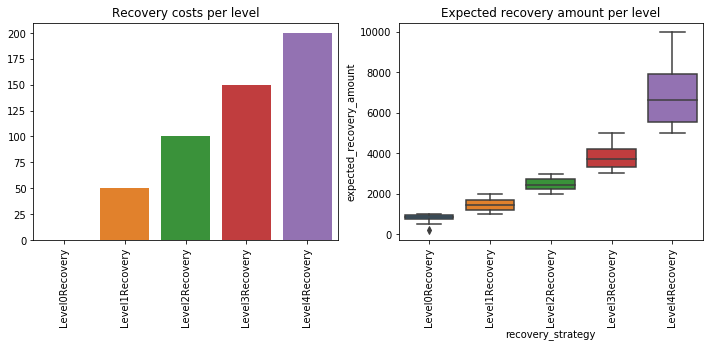

In [23]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

cost=np.arange(0,250,50 )
levels=debt.recovery_strategy.unique().tolist()

ax1 = sns.barplot(x=levels, y=cost, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels() , rotation=90)
ax1.set_title("Recovery costs per level")

ax2=sns.boxplot(x="recovery_strategy", y='expected_recovery_amount', 
                 data=debt, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels() , rotation=90)
ax2.set_title("Expected recovery amount per level")


plt.show()

## Data modeling
<p>
starting with determining the range of the recovery levels in
terms of expected_recovery_amount.
</p> 


In [24]:

recover_agg = debt.groupby('recovery_strategy')['expected_recovery_amount'].aggregate(['min', 'max'])
print(type(recover_agg))
recover_agg['range'] = recover_agg['max'] - recover_agg['min']
print(recover_agg )
print(recover_agg.shape)
print(recover_agg.index)

<class 'pandas.core.frame.DataFrame'>
                    min   max  range
recovery_strategy                   
Level0Recovery      194  1000    806
Level1Recovery     1001  1997    996
Level2Recovery     2001  2992    991
Level3Recovery     3002  4987   1985
Level4Recovery     5008  9964   4956
(5, 3)
Index(['Level0Recovery', 'Level1Recovery', 'Level2Recovery', 'Level3Recovery',
       'Level4Recovery'],
      dtype='object', name='recovery_strategy')


In [25]:
# subsetting minimum colum from recover_agg above, 
# this are threshold values
recover_agg_min = recover_agg.loc['Level1Recovery':'Level4Recovery','min']
thresholds_df = recover_agg_min.to_frame()
thresholds_df.reset_index(inplace=True)

thresholds_df['low'] = thresholds_df['min'] - 100
thresholds_df['up'] = thresholds_df['min'] + 100
thresholds_df['recovery_strategy'] = ['threshold_0_1', 'threshold_1_2', 'threshold_2_3', 'threshold_3_4']
thresholds_df.rename(columns={'recovery_strategy': 'threshold_areas'}, inplace=True)

print(type(thresholds_df))
print(thresholds_df)



<class 'pandas.core.frame.DataFrame'>
  threshold_areas   min   low    up
0   threshold_0_1  1001   901  1101
1   threshold_1_2  2001  1901  2101
2   threshold_2_3  3002  2902  3102
3   threshold_3_4  5008  4908  5108


In [26]:
# Creating lower and upper boundaries
low = thresholds_df.low.to_list()
print(low)
up = thresholds_df.up.to_list()
print(up)
threshold_areas = thresholds_df.threshold_areas.to_list()
print(threshold_areas)

[901, 1901, 2902, 4908]
[1101, 2101, 3102, 5108]
['threshold_0_1', 'threshold_1_2', 'threshold_2_3', 'threshold_3_4']


In [27]:
# check boundaries
for i,m  in zip(low,up):
    print(i,m)

901 1101
1901 2101
2902 3102
4908 5108


Conceptually expected recovery amount changes at the threshold or between recovery strategies. Does the other variables change also at the threshold? For example does the sex female jumps after threshold 2 or age 
decreases after threshold 3?

#### Age: Are there any differences or jumps in age at the threshold between the levels of expected_recovery_amount?
<p>Answering with viszualization.</p> 


In [28]:
a2 = np.linspace(0,8000, num=5, dtype='int').tolist()
print(a2)
a3 = np.linspace(2000,10000, num=5, dtype='int').tolist()
print(a3)

[0, 2000, 4000, 6000, 8000]
[2000, 4000, 6000, 8000, 10000]


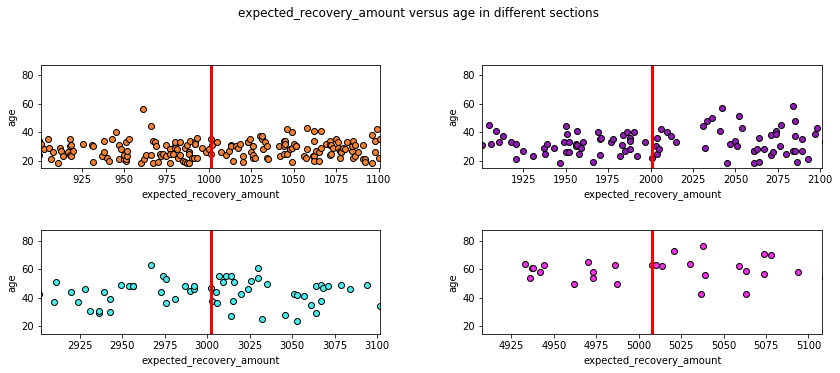

In [29]:


fig = plt.figure(figsize=(14,8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
fig.suptitle("expected_recovery_amount versus age in different sections")
for n, (i,j) in enumerate(zip(low, up)):
        ax = fig.add_subplot(3, 2, n+1)
        ax = plt.scatter(debt['expected_recovery_amount'], debt['age'], 
                         c=color_list[n], edgecolor='black')
        ax = plt.xlabel('expected_recovery_amount')
        ax = plt.ylabel('age')
        ax = plt.xlim(i,j)
        ax = plt.axvline(x=low[n] + 100, linewidth=3, color='red')


There are no jumps at the thresholds visible. This indicates age influences <b>not</b> expected_recovery_amount.

#### Age: Is there a difference in (median) age at the threshold between Level0Recovery and Level1Recovery?

<p>Answering numerical with a test.</p> 

In [30]:
print(debt.groupby('recovery_strategy')['expected_recovery_amount'].nunique())
print(debt.groupby('recovery_strategy')['age'].nunique())

recovery_strategy
Level0Recovery    186
Level1Recovery    478
Level2Recovery    276
Level3Recovery    336
Level4Recovery    253
Name: expected_recovery_amount, dtype: int64
recovery_strategy
Level0Recovery    26
Level1Recovery    33
Level2Recovery    45
Level3Recovery    51
Level4Recovery    40
Name: age, dtype: int64


In [31]:
threshold_1 = ((debt['expected_recovery_amount'] < 1100) & (debt['expected_recovery_amount'] >= 900))

print(type(threshold_1))
print(threshold_1.sum())
print(threshold_1.shape)

threshold_1_df = debt[threshold_1]

print(threshold_1_df.head())


<class 'pandas.core.series.Series'>
183
(1882,)
         id  expected_recovery_amount  actual_recovery_amount  \
index                                                           
158     520                       900                     505   
159    1036                       900                     540   
160    1383                       900                     555   
161     998                       901                     887   
162    1351                       903                     667   

      recovery_strategy  age     sex  
index                                 
158      Level0Recovery   34    Male  
159      Level0Recovery   34  Female  
160      Level0Recovery   24    Male  
161      Level0Recovery   32    Male  
162      Level0Recovery   28    Male  


In [32]:
print(threshold_1_df['age'].describe())
print(threshold_1_df['expected_recovery_amount'].describe())

count    183.000000
mean      28.010929
std        6.159054
min       18.000000
25%       23.000000
50%       28.000000
75%       32.000000
max       56.000000
Name: age, dtype: float64
count     183.000000
mean     1005.464481
std        56.618713
min       900.000000
25%       964.500000
50%      1002.000000
75%      1056.500000
max      1099.000000
Name: expected_recovery_amount, dtype: float64


In [33]:
# age at Level0Recovery of expected recovery amout between 900 and 1100
age_0_threshold = threshold_1_df.loc[threshold_1_df['recovery_strategy'] == 'Level0Recovery']['age']
print(age_0_threshold.shape)
print(age_0_threshold[:5])
# age at Level1Recovery of expected recovery amout between 900 and 1100
age_1_threshold = threshold_1_df.loc[threshold_1_df['recovery_strategy'] == 'Level1Recovery',]['age']
print(age_1_threshold.shape)
print(age_1_threshold[:5])

(89,)
index
158    34
159    34
160    24
161    32
162    28
Name: age, dtype: int64
(94,)
index
247    35
248    25
249    31
250    33
251    26
Name: age, dtype: int64


### Kruskal-Wallis H-test

<p>
The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. 
It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, 
which may have different sizes. Note that rejecting the null hypothesis does not indicate which 
of the groups differs. Post-hoc comparisons between groups are required to 
determine which groups are different.
</p> 
<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html">
scipy.stats.kruskal</a> 
<p>
Applied significance level: 0.05
</p> 

In [34]:
kruskal_statistic_1, kruskal_pvalue_1  = stats.kruskal(age_0_threshold, age_1_threshold) 
print(kruskal_statistic_1, kruskal_pvalue_1)
print(kruskal_pvalue_1 > 0.05)

3.4572342749517513 0.06297556896097407
True


The null-hypothesis that population median of of age of at Level0Recovery is equal 
to population median of of age of at Level1Recovery cannot be rejected. 
This indicates that age influences not expected recovery amout between 900 and 1100.

#### Age: Is there a difference in (median) age at the threshold between levels of recovery strategy?
<p>Answering numerical with tests.</p> 

In [35]:
recovery_levels_low = list(debt['recovery_strategy'].unique()[0:4])
print(recovery_levels_low)
recovery_levels_up = list(debt['recovery_strategy'].unique()[1:5])
print(recovery_levels_up)
print(recovery_levels_low[0])

['Level0Recovery', 'Level1Recovery', 'Level2Recovery', 'Level3Recovery']
['Level1Recovery', 'Level2Recovery', 'Level3Recovery', 'Level4Recovery']
Level0Recovery


In [36]:
kruska_statistics = []
kruska_pvalues = []

for u, (i,m) in enumerate(zip(low,up)):
    threshold_range = (debt['expected_recovery_amount'] >= i) & (debt['expected_recovery_amount'] <= m)
    threshold_df = debt[threshold_range]

    age_low = threshold_df.loc[threshold_df['recovery_strategy'] == recovery_levels_low[u], 'age']
    age_up = threshold_df.loc[threshold_df['recovery_strategy'] == recovery_levels_up[u], 'age']
    
    statistic, pvalue  = stats.kruskal(age_up, age_low) 
    kruska_statistics.append(statistic)
    kruska_pvalues.append(pvalue)




In [37]:
kruska_pvalues=kruska_pvalues[::-1] 
kruska_statistics=kruska_statistics[::-1]

In [38]:
kruska_df = pd.DataFrame(list(zip(threshold_areas, kruska_statistics, kruska_pvalues)), 
                              columns=['threshold_areas', 'statistic', 'p_value'])

kruska_df['null_hypothesis'] = np.where(kruska_df['p_value'] > 0.05, 'not reject', 'reject')

kruska_df.sort_values(by='threshold_areas')

,threshold_areas,statistic,p_value,null_hypothesis
0,threshold_0_1,1.107356,0.292657,not reject
1,threshold_1_2,0.043022,0.835684,not reject
2,threshold_2_3,0.924097,0.336402,not reject
3,threshold_3_4,4.094912,0.043012,reject


The null-hypothesis states that the median between the two populations is equal.
This implies that the distribution have the same shape.
This is true for the threshold ares 1 to 23.
At threshold_3_4 it is rejected.
This also the threshold with the highest deviations and the lowest number of samples.

    

#### Sex: Is there on average a different before and after the threshold between 901 and 1001 of recovery strategy with regard to sex?

<p>Answering numerical with a chi square test.</p> 

In [39]:
# Number of customers in each category
crosstab = pd.crosstab(debt.loc[(debt['expected_recovery_amount']<1101) & 
                              (debt['expected_recovery_amount']>=901)]['recovery_strategy'], 
                       debt['sex'], dropna=True)
print(crosstab)

sex                Female  Male
recovery_strategy              
Level0Recovery         31    55
Level1Recovery         40    55


### Chi-square test
<p>
The null hypothesis states: there is no difference between the expected and observed frequencies of the sampling distribution.
The test is based on frequency tables, where the intersections between the variables are stored as frequencies in the cells.
</p>

<p>What we want to know here whether the expected and observed frequencies of recovery_strategy and sex are different or not
for certain sections of the expected_recovery_amount.
If the frequencies are different and the null hypothesis is rejected then the frequencies of sex are changing unexpectedly after the thresholds.
For example at Level1Recovery the number of females is increasing unexpectedly.
</p>

<p>The significance level is set here at 0.05</p>

In [40]:
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

0.49569867432047543


#### Sex: Are there on average a differences before and after the thresholds of all levels of recovery strategy with regard to sex?

<p>Answering numerical with a chi squared tests.</p> 

In [41]:
print(low)
print(up)
areas = thresholds_df['threshold_areas']

[901, 1901, 2902, 4908]
[1101, 2101, 3102, 5108]


In [45]:

crosstab_levels = []
chi_areas = []
chi_p = []
chi2 = []

for u, (i,m) in enumerate(zip(low,up)):
    crosstab = \
    pd.crosstab(debt.loc[(debt['expected_recovery_amount']<m) & 
                         (debt['expected_recovery_amount']>=i)]['recovery_strategy'], 
                debt['sex'], dropna=True)
    
    crosstab_levels.append(crosstab)
    
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)

    
    chi_areas.append(areas[u])
    chi_p.append(p_val)
    chi2.append(chi2_stat)
    
    # check
    # print(i,m)


chi_results = pd.DataFrame(list(zip(chi_areas, chi_p, chi2)), columns=['threshold_areas', 'p_value', 'chi2'])


# Reject the null hypothesis. The null hypothesis states:
# there is no difference between the expected and observed frequencies of the given data.
chi_results['Reject?'] = np.where(chi_results.p_value > 0.05, 'not reject', 'reject')

print(chi_results)


  threshold_areas   p_value      chi2     Reject?
0   threshold_0_1  0.495699  0.464133  not reject
1   threshold_1_2  0.531425  0.391667  not reject
2   threshold_2_3  0.405122  0.693071  not reject
3   threshold_3_4  0.321958  0.980975  not reject


The p_value at threshold_0_1 calculated with the for loop is identical to the p_value without for loop of 0.495699.
This indicates the for loop works.

<p>More important no null-hypothesis is rejected for each level. This means the expected and observed frequencies are similar and age changes not at the thresholds.
Customers before and below the threshold have on average a similar mean.</p> 

In [46]:
for i,m in zip(areas, crosstab_levels):
    print(i)
    print(m)

threshold_0_1
sex                Female  Male
recovery_strategy              
Level0Recovery         31    55
Level1Recovery         40    55
threshold_1_2
sex                Female  Male
recovery_strategy              
Level1Recovery         22    25
Level2Recovery         18    29
threshold_2_3
sex                Female  Male
recovery_strategy              
Level2Recovery         10    15
Level3Recovery         18    15
threshold_3_4
sex                Female  Male
recovery_strategy              
Level3Recovery          8     4
Level4Recovery          6     9


#### actual_recovery_amount: Are there a differences or jumps in actual_recovery_amount at the threshold between the levels of recovery strategy in sections of expected_recovery_amount?

<p>Answering with viszualization.</p> 

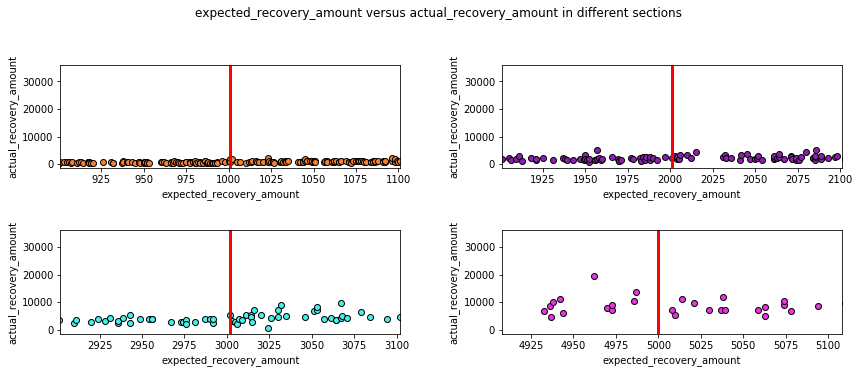

In [47]:
vertical=[901, 1901, 2902, 4900]
fig = plt.figure(figsize=(14,8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
fig.suptitle("expected_recovery_amount versus actual_recovery_amount in different sections")
for n, (i,j) in enumerate(zip(low, up)):
        ax = fig.add_subplot(3, 2, n+1)
        ax = plt.scatter(debt['expected_recovery_amount'], 
                         debt['actual_recovery_amount'], 
                         c=color_list[n], edgecolor='black')
        ax = plt.xlabel('expected_recovery_amount')
        ax = plt.ylabel('actual_recovery_amount')
        ax = plt.xlim(i,j)
        ax = plt.axvline(x=vertical[n] + 100, linewidth=3, color='red')


There are no jumps at the thresholds visible. However in the range of 8.000 to 10.000 the fluctuation and deviation are very high. This makes it harder to determine changes in this section of expected recovery amount.
Does the Kruskal-Wallis test confirm this answer?

### Answering with Kruskal-Wallis H-test.

In [48]:
kruska_statistics_2 = []
kruska_pvalues_2 = []

for u, (i,m) in enumerate(zip(low,up)):
    threshold_range = (debt['expected_recovery_amount'] >= i) & (debt['expected_recovery_amount'] <= m)
    threshold_df = debt[threshold_range]

    act_low = threshold_df.loc[threshold_df['recovery_strategy'] == recovery_levels_low[u], 'actual_recovery_amount']
    act_up = threshold_df.loc[threshold_df['recovery_strategy'] == recovery_levels_up[u], 'actual_recovery_amount']
    
    statistic, pvalue  = stats.kruskal(act_up, act_low) 
    kruska_statistics_2.append(statistic)
    kruska_pvalues_2.append(pvalue)

In [49]:
print(kruska_statistics_2)
print(kruska_pvalues_2)

[62.80561216595514, 18.481022704319972, 14.008470588235298, 0.6880952380952436]
[2.2814781899315703e-15, 1.71604531630211e-05, 0.00018198893303818348, 0.4068130174209713]


In [50]:
kruskal_act = pd.DataFrame(list(zip(kruska_statistics_2, kruska_pvalues_2)), columns=['chi' , 'pvalue'])
kruskal_act['reject ?'] = np.where(kruskal_act.pvalue > 0.05, 'not reject', 'reject')

kruskal_act

,chi,pvalue,reject ?
0,62.805612,2.281478e-15,reject
1,18.481023,1.716045e-05,reject
2,14.008471,1.819889e-04,reject
3,0.688095,4.068130e-01,not reject


The population median below and above the thresholds is not equal for areas 1 to 3.
This implies that 'actual_recovery_amount' changes significantly with recovery strategy.
This contradicts the visual representation, but the test is more valid to measure the differences
than the plots.

### Regression analysis
<p>
Regression analysis focuses other than machine learning regression not mainly on predictions but on determining 
the characteristics of the relationsip between independent and dependent variables.
Characteristics are for example the direction and the strength of the relationship or the goodness of fit of the model.
The R-squared as the variance explained by the model is interpreted here.
</p> 

<p>
In the first step the regression analysis with expected_recovery_amount as the independent and
actual_recovery_amount as the dependent variable is conducted over the whole data set.
</p> 

In [51]:

# Define X and y
X = debt['expected_recovery_amount']
y = debt['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
debt_model = sm.OLS(y, X).fit()

predictions = debt_model.predict(X)
print(predictions[:5])

# Print out the model summary statistics
debt_model.summary()

C:\Users\gamarandor\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


index
0   -1253.247138
1    -655.332246
2    -571.378442
3    -552.949559
4    -542.711290
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.817
Model:                                OLS   Adj. R-squared:                  0.817
Method:                     Least Squares   F-statistic:                     8378.
Date:                    Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                            09:12:19   Log-Likelihood:                -16936.
No. Observations:                    1882   AIC:                         3.388e+04
Df Residuals:                        1880   BIC:                         3.389e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1650.4920     76.506    -21.573      0.000   -1800.537   -1500.447
expected_recovery_amount     2.0477      0.022     91.530      0.000       2.004       2.092
==============================================================================
Omnibus:                     1477.254   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77457.864
Skew:                           3.224   Prob(JB):                         0.00
Kurtosis:                      33.760   Cond. No.                     5.79e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>Interpretation</b>: The R-squared or coefficient of determination is with 0.817 high. The variance explained by the model of the overall variance is ca. 81 %. This indicates high goodnes of fit. The coefficient is positive. This indicates a positive relationship.Given a one unit shift in expected_recovery_amount the dependent variable actual_recovery_amountshifts 2.0477 units while all other variables are staying constant.
The coefficient for expected_recovery_amount is significantly different from 0 because its p-value is 0.000, which is smaller than 0.05. 

### Regression analysis within subset 900 to 1100

In [52]:
debt_subset_34 = (debt['expected_recovery_amount'] >= 900) & (debt['expected_recovery_amount'] <= 1100)
debt_subset_34_df = debt[debt_subset_34]

# print(debt_subset_34_df.info())
print(debt_subset_34_df.shape)
print(debt.shape)

(184, 6)
(1882, 6)


In [53]:

# Define X and y
X = debt_subset_34_df['expected_recovery_amount']
y = debt_subset_34_df['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
debt_subset_34_model = sm.OLS(y, X).fit()
predictions = debt_subset_34_model.predict(X)

# Print out the model summary statistics
debt_subset_34_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.252
Model:                                OLS   Adj. R-squared:                  0.248
Method:                     Least Squares   F-statistic:                     61.45
Date:                    Tue, 08 Oct 2019   Prob (F-statistic):           3.69e-13
Time:                            09:12:19   Log-Likelihood:                -1286.5
No. Observations:                     184   AIC:                             2577.
Df Residuals:                         182   BIC:                             2583.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1917.8468    346.410     -5.536      0.000   -2601.343   -1234.350
expected_recovery_amount     2.6950      0.344      7.839      0.000       2.017       3.373
==============================================================================
Omnibus:                       64.510   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.631
Skew:                           1.457   Prob(JB):                     4.91e-41
Kurtosis:                       6.965   Cond. No.                     1.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>Interpretation</b>: The R-squared or coefficient of determination is with 0.248 low. 
The variance explained by the model of the overall variance is ca. 24 %. 
This indicates low goodness of fit, but maybe less critical considering the small sample.
The coefficient is positive. This indicates a positive relationship.Given a one unit shift in 
expected_recovery_amount the dependent variable actual_recovery_amount shifts 2.6950 units while 
all other variables are staying constant. The coefficient for expected_recovery_amount is significantly different from 0 because its p-value is 0.000, which is smaller than 0.05. 

In [54]:
debt_subset_555_df = debt_subset_34_df.copy()
# Create indicator (0 or 1) for expected recovery amount >= $1000
debt_subset_555_df['indicator_1000'] = np.where(debt_subset_555_df['expected_recovery_amount']<1000, 0, 1)

# check
print(debt_subset_555_df.columns.tolist())
print(debt_subset_555_df['indicator_1000'].isnull().sum())
print(debt_subset_555_df['indicator_1000'].sum())

['id', 'expected_recovery_amount', 'actual_recovery_amount', 'recovery_strategy', 'age', 'sex', 'indicator_1000']
0
96


In [61]:


#  df[['variable_1','variable_2']]
# Define X and y
X = debt_subset_555_df[['expected_recovery_amount', 'indicator_1000']]
# check: print(X)
y = debt_subset_555_df['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
debtmodel_55 = sm.OLS(y,X).fit()

# Print the model summary
debtmodel_55 .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.309
Model:                                OLS   Adj. R-squared:                  0.301
Method:                     Least Squares   F-statistic:                     40.42
Date:                    Tue, 08 Oct 2019   Prob (F-statistic):           3.06e-15
Time:                            11:06:02   Log-Likelihood:                -1279.3
No. Observations:                     184   AIC:                             2565.
Df Residuals:                         181   BIC:                             2574.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      100.7826    622.656      0.162      0.872   -1127.814    1329.380
expected_recovery_amount     0.5410      0.651      0.830      0.407      -0.744       1.826
indicator_1000             284.2193     73.987      3.841      0.000     138.231     430.208
==============================================================================
Omnibus:                       66.393   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.174
Skew:                           1.512   Prob(JB):                     1.38e-41
Kurtosis:                       6.924   Cond. No.                     3.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>Interpretation</b>: The R-squared or coefficient of determination is with 0.301 low. 
The variance explained by the model of the overall variance is ca. 30 %. 
This indicates low goodness of fit, but maybe less critical considering the small sample.
The coefficient is positive. This indicates a positive relationship. Given a one unit shift in 
indicator_1000 the dependent variable actual_recovery_amount shifts  284.2193 units while 
all other variables are staying constant. The coefficient for indicator_1000 is 
significantly different from 0 because its p-value is 0.000, which is smaller than 0.05. 

<b>Conclusion</b>: actual_recovery_amount shifts $284.2193 given a one unit shift in the success case of indicator_1000. Given a 50 Dollar to take action to collect it makes sense to do the effort.
This is hereby proven with inferential statistics.